https://www.youtube.com/watch?v=TCH_1BHY58I

In this exercise we accomplish the following. this notebook is based on https://github.com/karpathy/nn-zero-to-hero/tree/master/lectures/makemore

first is a simple MLP (Multi Layer Perceptron) model. we implement https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf paper.\
But instead of doing it a word level we will be doing it at a character level.

In bigram we took only one character context.
So the freq count needed 27 x 27 matrix.
if we were to take a 3 character context it will need 27^3 x 27 matrix.
Therefore it grows exponentaially


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(f'{words[:8]=}')
print(f'{len(words)=}')

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(f'{itos=}')

words[:8]=['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
len(words)=32033
itos={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [3]:
block_size = 3 # context length: how many characters do we take to predict the next one?
# in the bigram lecture it took only one character of context.

We are working with a large number of parameters.\
to avoid overfitting we have to split the data into the following: \
\
**training set**\
**dev / validation set**\
**test set**

In [4]:
def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
C = torch.randn((27, 2))

## PyTorch Concept:

Now we have the C initialized to random 27 X 2 matrix.\
basically we are taking 2 dimensions for each character.\
\
now we have X which contains character index 0 - 26. \
we want a shortcut embedding for this now.\

https://www.youtube.com/watch?v=TCH_1BHY58I&t=739s

In [6]:
a = Xtr[1][2]

# indexing like regular python 
print(f'{Xtr[1][2]=}')
print(f'{C[a]=}')
print()

# one hot is what we used in bigram in lecture one. we are not going to use it but here is an example
one_hot = F.one_hot(torch.tensor([a]), num_classes=27).float()
print(f'{one_hot=}')
print(f'{one_hot @ C=}')
print()

# so we have a shortcut instead of doing it for every Xtr individually.
emb = C[Xtr]
print(f'{emb[1][2]=}')
print()

print(f'{C.shape=}')
print(f'{Xtr.shape=}')
print(f'{emb.shape=}')

Xtr[1][2]=tensor(25)
C[a]=tensor([1.7894, 0.2208])

one_hot=tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0.]])
one_hot @ C=tensor([[1.7894, 0.2208]])

emb[1][2]=tensor([1.7894, 0.2208])

C.shape=torch.Size([27, 2])
Xtr.shape=torch.Size([182625, 3])
emb.shape=torch.Size([182625, 3, 2])


In [7]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [8]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [9]:
h

tensor([[ 0.9944, -0.9997, -0.7935,  ...,  0.8963, -0.9946,  0.9988],
        [-0.8992, -0.9890, -0.6456,  ..., -0.7358, -0.9997,  0.9994],
        [ 0.9117,  0.2167,  0.8894,  ..., -0.9996, -0.9860,  0.9355],
        ...,
        [-0.9647, -0.9811, -0.7019,  ..., -0.7106, -0.7876,  0.9964],
        [-0.9982, -0.8856,  0.9349,  ..., -0.9847, -0.9076, -0.9987],
        [ 0.8717, -0.7709,  0.9937,  ..., -0.9892,  0.3643, -0.9954]])

In [10]:
h.shape

torch.Size([182625, 100])

In [11]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [12]:
logits = h @ W2 + b2

In [13]:
logits.shape

torch.Size([182625, 27])

In [14]:
counts = logits.exp()

In [15]:
prob = counts / counts.sum(1, keepdims=True)

In [16]:
prob.shape

torch.Size([182625, 27])

In [17]:
loss = -prob[torch.arange(Xtr.shape[0]), Ytr].log().mean()
loss

tensor(15.3710)

# Now made respectable

In [18]:
# number of dimensions for the characters. Imagine each dimension as a property of the character.
dimensions = 10

In [19]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((27, dimensions), generator=g)
W1 = torch.randn((dimensions * block_size, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [20]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [21]:
for p in parameters:
  p.requires_grad = True

## NN Concept: Finding the best loss rate

here we are going to plot the loss rate and the loss. \
based on that we identify that 0.1 is a good rate. \
<span style="color:red">that peice of code has been removed.</span> \
we have made the code such that at first it is 0.1 and then we reduce it to 0.01.

In [22]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [23]:
lri = []
lossi = []
stepi = []

## NN Concept: Mini Batch

Instead of running the training for all the training data and making gradient decent.\
Here we will introduce **mini batch** which we select a random subset of the training set.\
Using that subset we are able to do many iterations of gradient decent.

Making small adjustments yields us good results compared to making big adjustments based on all the training data.

In [24]:
batch_size = 64

In [25]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  
  # forward pass
  emb = C[Xtr[ix]] # (batch_size, block_size, dimensions) (64, 3, 10)
  h = torch.tanh(emb.view(-1, block_size * dimensions) @ W1 + b1) # (batch_size, 200)
  logits = h @ W2 + b2 # (batch_size, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(f'loss (at mini batch level not that useful) = {loss.item()}')

loss (at mini batch level not that useful) = 2.226189136505127


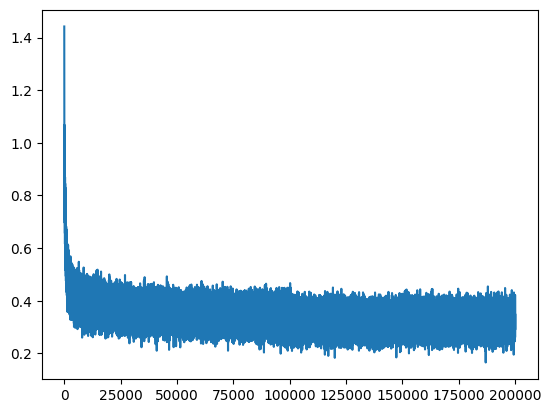

In [26]:
plt.plot(stepi, lossi)

In [27]:
emb = C[Xtr] # (batch_size, 3, 2)
h = torch.tanh(emb.view(-1, block_size * dimensions) @ W1 + b1) # (batch_size, 100)
logits = h @ W2 + b2 # (batch_size, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1218, grad_fn=<NllLossBackward0>)

## PyTorch Concept: cross_entropy

instead of implementing negative log probability manually like we did in lecture 1 of bigrams \
we will be using inbuilt `cross_entropy` method. \
If you remember micrograd implementation you will remember using complex methods like tanh\
gives us a chance to do forward, backward propagation more efficiently.

In [28]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * dimensions) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1616, grad_fn=<NllLossBackward0>)

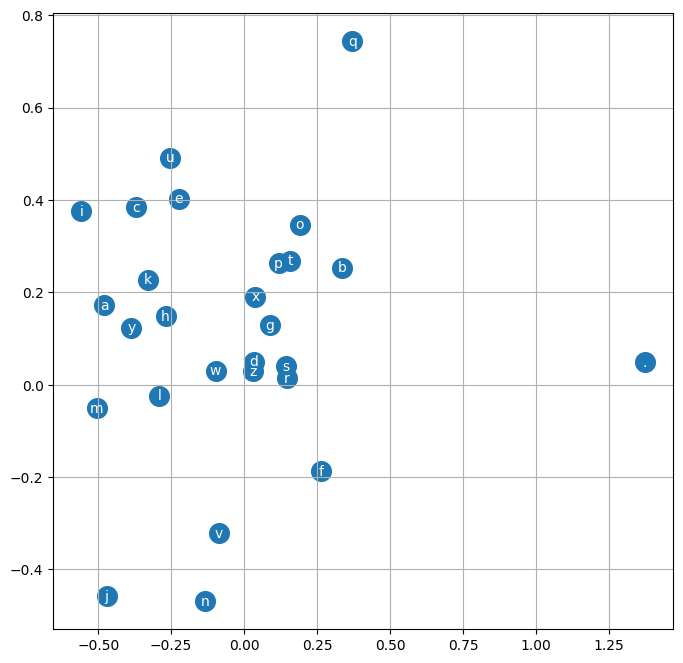

In [29]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [30]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [31]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [32]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
amelle.
khi.
mili.
taty.
skanden.
jazheen.
delyah.
jareei.
nellara.
chaiir.
kaleigh.
ham.
jorn.
quintis.
lilea.
jadbi.
wazell.
dearyxikah.
eveighan.
